### 1. Data preprocessing

In [1]:
%matplotlib inline
plt.style.use('bmh')
# %matplotlib widget

# 1) read data
df = pd.read_csv('data/input.csv')
print(df.shape)

# 2) preprocessing
df.drop_duplicates(subset = ['CODI EOI','DATA','CONTAMINANT'], inplace = True)
print(df.shape)
dict_repl = {
    "Ribera d¿Ebre": "Ribera d'Ebre"
}
df['NOM COMARCA'] = df['NOM COMARCA'].map(lambda x: dict_repl[x] if x in dict_repl else x)
df['DATA'] = pd.to_datetime(df['DATA'], dayfirst = True)

df['year'] = df['DATA'].dt.year
df['month'] = df['DATA'].dt.month
df['weekday'] = df['DATA'].dt.dayofweek
df['year_month'] = pd.to_datetime(df['DATA'].astype(str).str[:7] + '-01')

# 3) features lists
feats10 = ['CODI EOI', 'CODI INE', 'CODI COMARCA', 'NOM ESTACIO', 'MUNICIPI', 'NOM COMARCA', 'ALTITUD']
feats11 = ['TIPUS ESTACIO', 'AREA URBANA', 'LATITUD','LONGITUD', 'GEOREFERENCIA']
feats2  = ['MAGNITUD', 'CONTAMINANT', 'UNITATS']

feat_dt     = ['DATA']
feats_vals  = ['01h','02h','03h','04h','05h','06h','07h','08h','09h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h','24h']

feats = feats10 + feats11 + feats2 + feat_dt + feats_vals

# 4) segmentation of pollutants
segm_old  = 'Cl2 HCNM HCT HCl PS'.split(' ')
segm_top  = 'NO NO2 NOX O3 PM10 SO2'.split(' ')
segm_rare = 'CO H2S C6H6 Hg PM1 PM2.5'.split(' ')

(3106374, 40)
(3106373, 40)


(88238, 13)


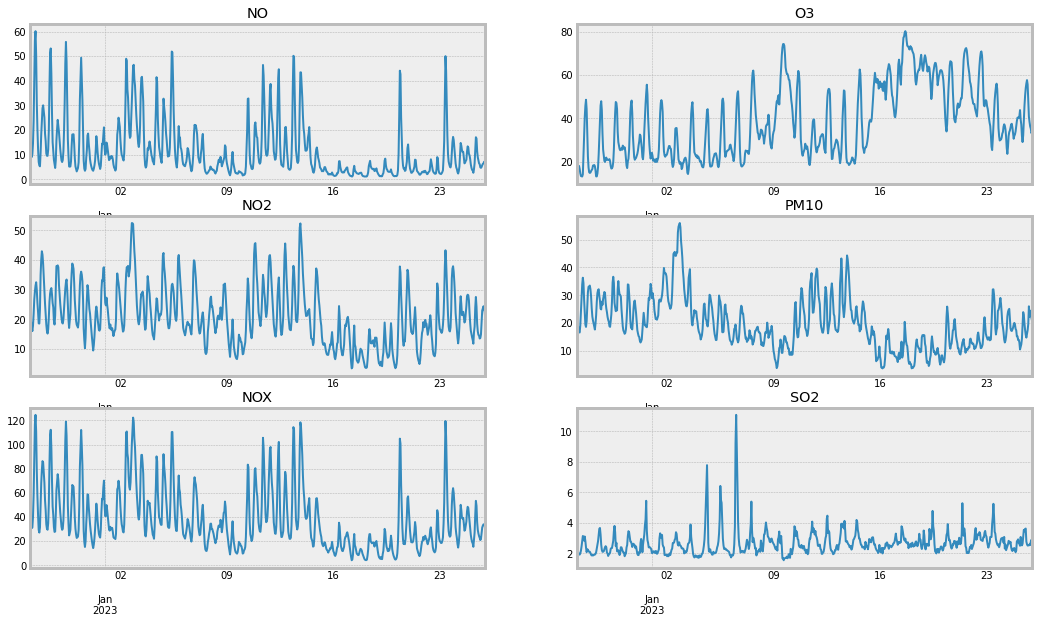

In [2]:
# 5) calculate averages by the hour for the years from 2013
from datetime import timedelta
# convert to long format
feats1 = ['DATA','CONTAMINANT']
filt = df.year >= 2013
df1 = df[filt].groupby(feats1)[feats_vals].mean()
df1 = df1.stack().reset_index().rename(columns = {0:'val','level_2':'hour'})

str2time = lambda x: ' ' + str(x)[:-1].replace('24','00') + ':00:00'
df1['dt_time'] = pd.to_datetime(df1.DATA.astype(str) + df1.hour.map(str2time))
del df1['DATA']
del df1['hour']
# 24h is 00h the next day - correction
df1['dt_time'] = df1.dt_time.map(lambda x: x + timedelta(days = 1 if x.hour == 0 else 0))

df1 = df1.groupby(['dt_time','CONTAMINANT'])['val'].max().unstack()
print(df1.shape)

df2 = df1[-1*30*24:]
# plotting
_, ax = plt.subplots(3,2, figsize = (16,10))
for i,feat in enumerate(segm_top[:3]):
    _ = df2[feat].plot(title = feat, ax = ax[i][0], xlabel = '')
for i,feat in enumerate(segm_top[3:]):
    _ = df2[feat].plot(title = feat, ax = ax[i][1], xlabel = '')

In [3]:
print(df1.shape)
df1[-3:]

(88238, 13)


CONTAMINANT,C6H6,CO,Cl2,H2S,Hg,NO,NO2,NOX,O3,PM1,PM10,PM2.5,SO2
dt_time,,,,,,,,,,,,,
2023-01-25 22:00:00,0.76,0.30,NaN,1.53,4.70,7.10,23.32,33.68,35.20,11.00,24.42,17.29,2.76
2023-01-25 23:00:00,0.86,0.31,NaN,1.63,4.80,7.32,22.59,33.33,33.14,10.00,21.89,17.29,2.89
2023-01-26 00:00:00,0.92,0.29,NaN,1.57,4.80,5.84,19.11,27.56,33.80,10.00,20.71,16.86,2.45


### 2. Models evaluation

In [4]:
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'mse': metrics.mean_squared_error(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
        'nmse':  np.sum((y_true - y_pred)**2) / np.sum((y_true)**2),
    }

#### Prophet

In [5]:
from prophet import Prophet

# 1) create datasets
feat = 'O3'
t1 = 24*14
x = df1[feat].reset_index()
x.columns = ['ds','y']
# splits
xt = x[-t1:]
x = x[:-t1]

# 2) build model
m = Prophet()
m.fit(x)

# 3) predict
df_out = m.make_future_dataframe(periods=t1, freq='h')
df_out = m.predict(df_out)
pred = df_out[-t1:].yhat.values
xt['pred_prophet'] = pred

# for future
df_preds = xt

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


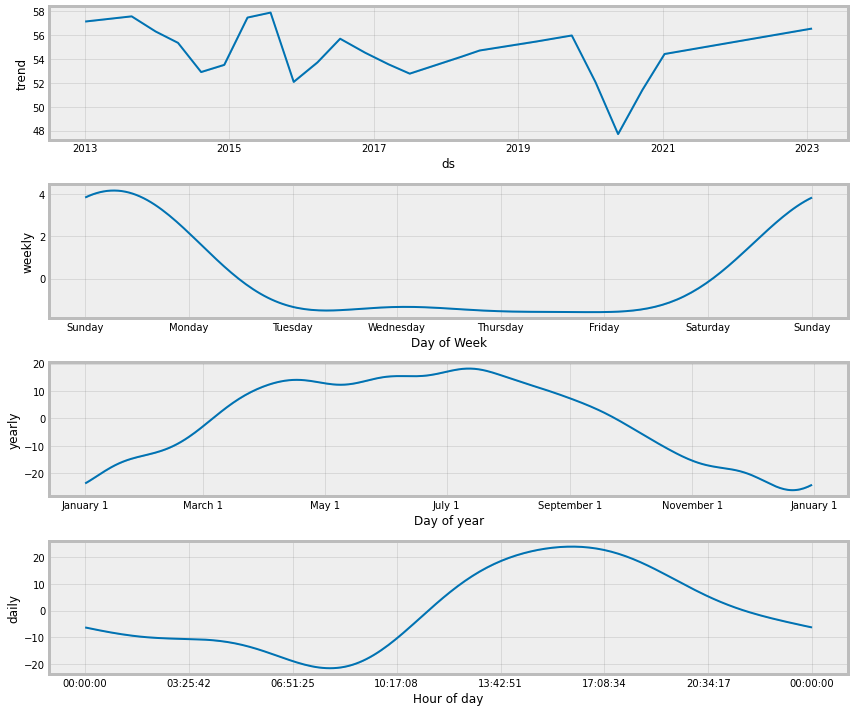

In [6]:
# explain predictions
m.plot_components(df_out, figsize = (12,10))
plt.show()

#### Random forest

In [7]:
# 1) create datasets
feat = 'O3'
t1 = 24*14
x = df1[feat].reset_index()
x.columns = ['ds','y']

# features from datetime
x['dayofyear'] = x.ds.dt.dayofyear
x['dayofweek'] = x.ds.dt.dayofweek
x['hour'] = x.ds.dt.hour

# x,y
x = x.set_index('ds')
y = x.y
del x['y']

# splits
xt = x[-t1:]
yt = y[-t1:]
x = x[:-t1]
y = y[:-t1]

# 2) train model
from sklearn import ensemble
model_rf = ensemble.RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1)
_ = model_rf.fit(x, y)

# 3) predict
pred = model_rf.predict(xt)
df_preds['pred_rf'] = pred

#### Xgboost

In [8]:
# 2) Training process
import xgboost as xgb

x_ = xgb.DMatrix(x.values, 
                label = y)
xv_ = xgb.DMatrix(xt.values, 
                label = yt) 

params = {
        'booster': 'gbtree',
        'tree_method': 'hist',
        'objective': 'reg:squarederror', 
        # 'eval_metric': 'logloss',
        'eta': 0.01,
        'max_depth': 5,  # -1 means no limit
        'subsample': 1,  # Subsample ratio of the training instance.
        'colsample_bytree': 1,  # Subsample ratio of columns when constructing each tree.
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': -1,
        'verbosity': 0
    }       

early_stopping_rounds = 10
num_boost_round       = 500

evals_results = dict()
model_xgb = xgb.train(params, 
             x_, 
             evals=[
                 (x_,'train'), 
                 (xv_,'valid'),
             ], 
             evals_result=evals_results, 
             num_boost_round=num_boost_round,
             early_stopping_rounds=early_stopping_rounds,
             verbose_eval=1000)

[0]	train-rmse:59.05996	valid-rmse:49.07241
[499]	train-rmse:11.75032	valid-rmse:16.59901


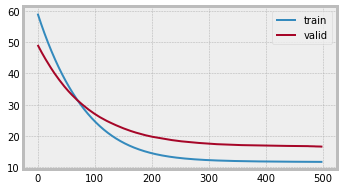

In [9]:
# Learning curve
df_evals = pd.DataFrame({
            'train': evals_results['train']['rmse'],
            'valid': evals_results['valid']['rmse'],
})
_ = df_evals.plot(figsize = (5,3))

In [10]:
# 3) prediction
pred = model_xgb.predict(xv_)
df_preds['pred_xgb'] = pred

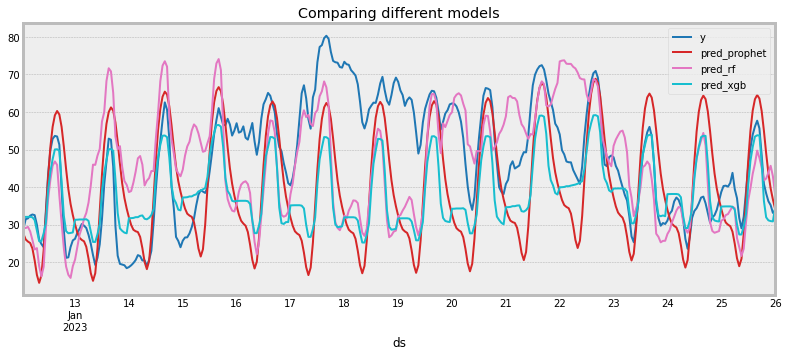

In [11]:
# plotting
df_preds = df_preds.set_index('ds')
_ = df_preds.plot(figsize = (12,5), cmap = 'tab10', title = 'Comparing different models')

In [12]:
# evaluation
out = list()
cols = df_preds.columns[1:]
for pred in cols:
    out.append(ts_metrics(df_preds.y, df_preds[pred]))
df_eval = pd.DataFrame(out, index = cols)
df_eval

,mae,mse,mape,smape,nmse
pred_prophet,13.85,318.67,0.30,0.33,0.13
pred_rf,13.42,281.86,0.32,0.30,0.11
pred_xgb,12.49,275.53,0.25,0.28,0.11


### 3. Best model predictions

[0]	train-rmse:59.02487
[499]	train-rmse:11.77472


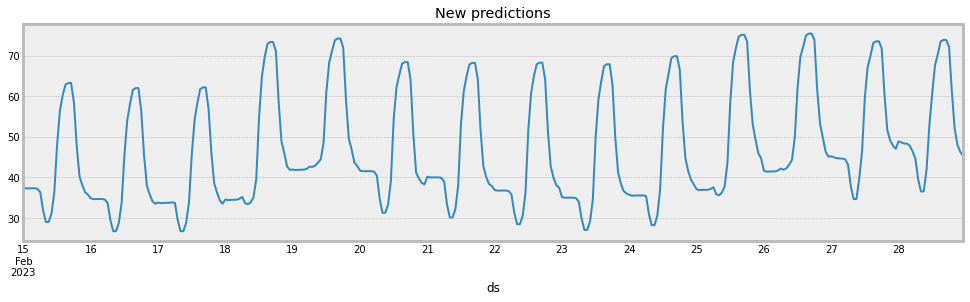

In [13]:
import xgboost as xgb

# 1) prepare dataframe
feat = 'O3'
t1 = 24*14
x = df1[feat].reset_index()
x.columns = ['ds','y']

# features from datetime
x['dayofyear'] = x.ds.dt.dayofyear
x['dayofweek'] = x.ds.dt.dayofweek
x['hour'] = x.ds.dt.hour

# x,y
x = x.set_index('ds')
y = x.y
del x['y']

# 2) build model
x_ = xgb.DMatrix(x.values, 
                label = y)

params = {
        'booster': 'gbtree',
        'tree_method': 'hist',
        'objective': 'reg:squarederror', 
        # 'eval_metric': 'logloss',
        'eta': 0.01,
        'max_depth': 5,  # -1 means no limit
        'subsample': 1,  # Subsample ratio of the training instance.
        'colsample_bytree': 1,  # Subsample ratio of columns when constructing each tree.
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': -1,
        'verbosity': 0
    }       

early_stopping_rounds = 10
num_boost_round       = 500

evals_results = dict()
model_xgb = xgb.train(params, 
             x_, 
             evals=[
                 (x_,'train'), 
                 # (xv_,'valid'),
             ], 
             evals_result=evals_results, 
             num_boost_round=num_boost_round,
             early_stopping_rounds=early_stopping_rounds,
             verbose_eval=1000)


# 3) predict

# features for new dataset
x = pd.DataFrame({'ds': pd.date_range(start = '2023-02-15', periods = t1, freq = 'h')})
x['dayofyear'] = x.ds.dt.dayofyear
x['dayofweek'] = x.ds.dt.dayofweek
x['hour'] = x.ds.dt.hour
x = x.set_index('ds')

x_ = xgb.DMatrix(x.values)
pred = model_xgb.predict(x_)
x['prediction'] = pred
df_out = x['prediction']
_ = df_out.plot(figsize = (15,4), title = 'New predictions')